# Optimizing Access Patterns

```{article-info}
:author: Altay Sansal
:date: "{sub-ref}`today`"
:read-time: "{sub-ref}`wordcount-minutes` min read"
:class-container: sd-p-0 sd-outline-muted sd-rounded-3 sd-font-weight-light
```

## Introduction

In this page we will be showing how we can take an existing MDIO and add
fast access, lossy, versions of the data in X/Y/Z cross-sections (slices).

We can re-use the MDIO dataset we created in the [Quickstart](#quickstart) page.
Please run it first.

We will define our compression levels first. We will use this to adjust the quality
of the lossy compression.

In [1]:
from enum import Enum


class MdioZfpQuality(float, Enum):
    """Config options for ZFP compression."""

    VERY_LOW = 6
    LOW = 3
    MEDIUM = 1
    HIGH = 0.1
    VERY_HIGH = 0.01
    ULTRA = 0.001

We will use the lower level `MDIOAccessor` to open the existing file in write mode that
allows us to modify its raw metadata. This can be dangerous, we recommend using only provided
tools to avoid data corruption.

We specify the original access pattern of the source data `"012"` with some parameters like
caching. For the rechunking, we recommend using the single threaded `"zarr"` backend to avoid
race conditions.

We also define a `dict` for common arguments in rechunking.

In [3]:
from mdio.api.accessor import MDIOWriter

mdio_path = "filt_mig.mdio"

writer = MDIOWriter(
    mdio_path_or_buffer=mdio_path,
    access_pattern="012",
    backend="zarr",
    disk_cache=False,
)

## Compression (Lossy)

Now, let's define our compression level. The compression ratios vary a lot
on the data characteristics. However, the compression levels here are good
guidelines that are based on standard deviation of the original data.

We use ZFP's fixed accuracy mode with a tolerance based on data standard
deviation, as mentioned above. For more ZFP options you can see its documentation.

Empirically, for this dataset, we see the following size reductions (per copy):

* `10  : 1` on `VERY_LOW`
* `7.5 : 1` on `LOW`
* `4.5 : 1` on `MEDIUM`
* `3   : 1` on `HIGH`
* `2   : 1` on `VERY_HIGH`
* `1.5 : 1` on `ULTRA`

In [4]:
from numcodecs import ZFPY
from zfpy import mode_fixed_accuracy

std = writer.stats["std"]  # standard deviation of original data

quality = MdioZfpQuality.LOW
tolerance = quality * std
sample_compressor = ZFPY(mode_fixed_accuracy, tolerance=tolerance)

common_kwargs = {"overwrite": True, "compressor": sample_compressor}

## Optimizing IL/XL/Z Independently

In this cell, we will demonstrate how to create IL/XL and Z (two-way-time) optimized
versions **independently**. In the next section we will do the same with the batch
mode where the data only needs to be read into memory once.

In the example below, each rechunking operation will read the data from the original
MDIO dataset and discard it. We did enable 256 MB (2^28 bytes) memory cache above,
it will help some, but still not ideal.

In [5]:
from mdio.api.convenience import rechunk

rechunk(writer, (4, 512, 512), suffix="fast_il", **common_kwargs)
rechunk(writer, (512, 4, 512), suffix="fast_xl", **common_kwargs)
rechunk(writer, (512, 512, 4), suffix="fast_z", **common_kwargs)

Rechunking to fast_z: 100%|██████████| 3/3 [00:01<00:00,  1.92chunk/s]


We can now open the original MDIO dataset and the fast access patterns.
When printing the `chunks` attribute, we see the original one first, and
the subsequent ones show data is rechunked with ZFP compression.

In [6]:
from mdio import MDIOReader

orig_mdio = MDIOReader(mdio_path)
il_mdio = MDIOReader(mdio_path, access_pattern="fast_il")
xl_mdio = MDIOReader(mdio_path, access_pattern="fast_xl")
z_mdio = MDIOReader(mdio_path, access_pattern="fast_z")

print(orig_mdio.chunks, orig_mdio._traces.compressors)
print(il_mdio.chunks, il_mdio._traces.compressors)
print(xl_mdio.chunks, xl_mdio._traces.compressors)
print(z_mdio.chunks, z_mdio._traces.compressors)

(64, 64, 64) (Blosc(cname='zstd', clevel=5, shuffle=SHUFFLE, blocksize=0),)
(4, 188, 512) (ZFPY(mode=4, tolerance=2.791618335971825, rate=-1, precision=-1),)
(345, 4, 512) (ZFPY(mode=4, tolerance=2.791618335971825, rate=-1, precision=-1),)
(345, 188, 4) (ZFPY(mode=4, tolerance=2.791618335971825, rate=-1, precision=-1),)


We can now compare the sizes of the compressed representations to original.

Below commands are for UNIX based operating systems and won't work on Windows.

In [7]:
!du -hs {mdio_path}/data/chunked_012
!du -hs {mdio_path}/data/chunked_fast_il
!du -hs {mdio_path}/data/chunked_fast_xl
!du -hs {mdio_path}/data/chunked_fast_z

149M	filt_mig.mdio/data/chunked_012
 21M	filt_mig.mdio/data/chunked_fast_il
 20M	filt_mig.mdio/data/chunked_fast_xl
 21M	filt_mig.mdio/data/chunked_fast_z


Comparing local disk read speeds for inlines:

In [8]:
%timeit orig_mdio[175]  # 3d chunked
%timeit il_mdio[175]  # inline optimized

23.5 ms ± 599 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.47 ms ± 77.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


For crosslines:

In [9]:
%timeit orig_mdio[:, 90]  # 3d chunked
%timeit xl_mdio[:, 90]  # xline optimized

51.2 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.96 ms ± 103 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Finally, for Z (time-slices):

In [10]:
%timeit orig_mdio[..., 751]  # 3d chunked
%timeit z_mdio[..., 751]  # time-slice optimized

8.21 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.35 ms ± 45.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We can check the subjective quality of the compression by visually comparing
two inlines. Similar to the example we had in the [Compression](#compression) page.

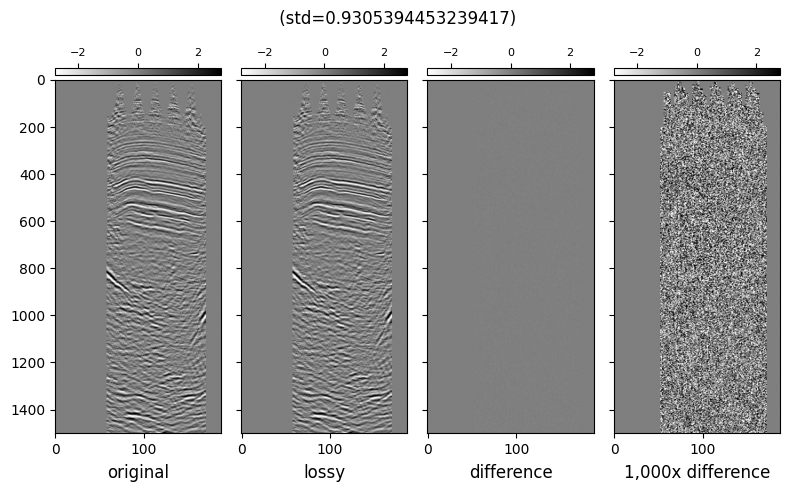

In [11]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.image import AxesImage
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.typing import NDArray

imshow_kw = {
    "vmin": -3 * std,
    "vmax": 3 * std,
    "cmap": "gray_r",
    "interpolation": "bilinear",
    "aspect": "auto",
}


def attach_colorbar(image: AxesImage, axis: Axes) -> None:
    """Attach a colorbar to an axis."""
    divider = make_axes_locatable(axis)
    cax = divider.append_axes("top", size="2%", pad=0.05)
    plt.colorbar(image, cax=cax, orientation="horizontal")
    cax.xaxis.set_ticks_position("top")
    cax.tick_params(labelsize=8)


def plot_image_and_cbar(data: NDArray, axis: Axes, title: str) -> None:
    """Plot an image with a colorbar."""
    image = axis.imshow(data.T, **imshow_kw)
    attach_colorbar(image, axis)
    axis.set_title(title, y=-0.15)


def plot_inlines_with_diff(orig: NDArray, compressed: NDArray, title: str) -> None:
    """Plot lossless and lossy inline with their differences."""
    fig, ax = plt.subplots(1, 4, sharey="all", sharex="all", figsize=(8, 5))

    diff = orig[200] - compressed[200]

    plot_image_and_cbar(orig[200], ax[0], "original")
    plot_image_and_cbar(compressed[200], ax[1], "lossy")
    plot_image_and_cbar(diff, ax[2], "difference")
    plot_image_and_cbar(diff * 1_000, ax[3], "1,000x difference")

    plt.suptitle(f"{title} ({std=})")
    fig.tight_layout()

    plt.show()


plot_inlines_with_diff(orig_mdio, il_mdio, "")

In conclusion, we show that by generating optimized, lossy compressed copies of the data
for certain access patterns yield big performance benefits when reading the data.

The differences are orders of magnitude larger on big datasets and remote stores, given available
network bandwidth.

## Optimizing in Batch

Now that we understand how rechunking and lossy compression works, we will demonstrate how
to do this in batches.

The benefit of doing the batched processing is that the dataset gets read once. This is
especially important if the original MDIO resides in a remote store like AWS S3, or Google
Cloud's GCS.

Note that we not are overwriting the old optimized chunks, just creating new ones with the
suffix 2 to demonstrate we can create as many version of the original data as we want.

In [12]:
from mdio.api.convenience import rechunk_batch

rechunk_batch(
    writer,
    chunks_list=[(4, 512, 512), (512, 4, 512), (512, 512, 4)],
    suffix_list=["fast_il2", "fast_xl2", "fast_z2"],
    **common_kwargs,
)

Rechunking to fast_il2,fast_xl2,fast_z2: 100%|██████████| 3/3 [00:03<00:00,  1.29s/chunk]


In [13]:
from mdio import MDIOReader

orig_mdio = MDIOReader(mdio_path)
il2_mdio = MDIOReader(mdio_path, access_pattern="fast_il2")
xl2_mdio = MDIOReader(mdio_path, access_pattern="fast_xl2")
z2_mdio = MDIOReader(mdio_path, access_pattern="fast_z2")

print(orig_mdio.chunks, orig_mdio._traces.compressors)
print(il_mdio.chunks, il2_mdio._traces.compressors)
print(xl_mdio.chunks, xl2_mdio._traces.compressors)
print(z_mdio.chunks, z2_mdio._traces.compressors)

(64, 64, 64) (Blosc(cname='zstd', clevel=5, shuffle=SHUFFLE, blocksize=0),)
(4, 188, 512) (ZFPY(mode=4, tolerance=2.791618335971825, rate=-1, precision=-1),)
(345, 4, 512) (ZFPY(mode=4, tolerance=2.791618335971825, rate=-1, precision=-1),)
(345, 188, 4) (ZFPY(mode=4, tolerance=2.791618335971825, rate=-1, precision=-1),)
